# Auxiliary functions to load CIFAR dataset

In [1]:
import random
import numpy as np
import os
import platform
from six.moves import cPickle as pickle

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_%d" % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y
    
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == "2":
        return pickle.load(f)
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")
    raise ValueError("invalid python version: {}".format(version))

# Load CIFAR dataset and visualize some examples

In [2]:
# Load the CIFAR-10 data.
cifar10_dir = 'cs/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2 #notebook will reload external python modules;

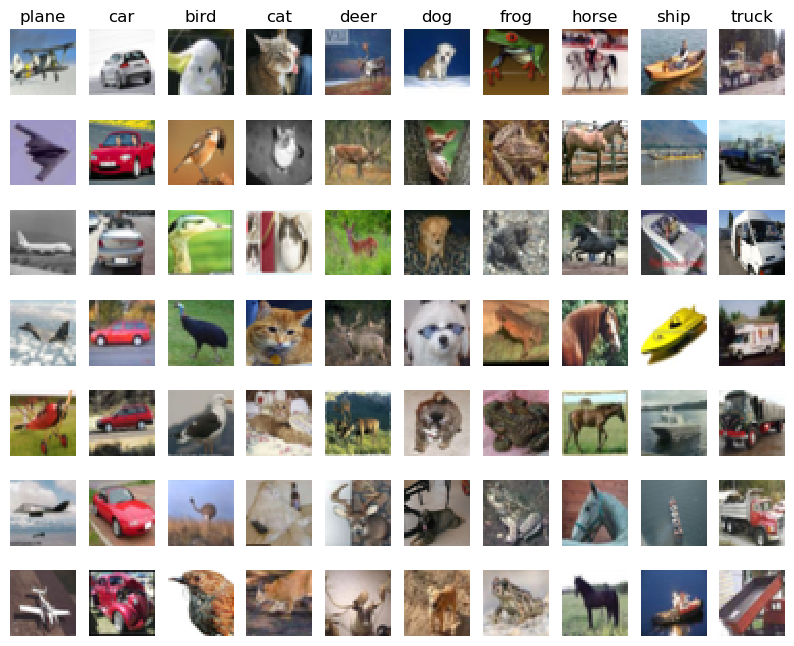

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, test, and development (subset of the training data) sets.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


#### Preprocessing

In [6]:
# reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


(3072,)
[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


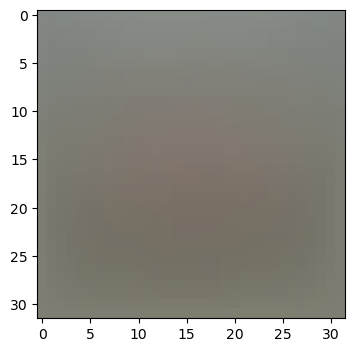

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [7]:
# subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image.shape)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

# SVM classifier

In [8]:
def svm_loss_naive(W, X, y, reg):
    """
    SVM loss, naive implementation (with loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape)  # initialize the gradient as zero

    num_classes = W.shape[1]
    num_train = X.shape[0]

    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1  # delta = 1
            if margin > 0:
                loss += margin
                dW[:, j] += X[i,:]
                dW[:, y[i]] -= X[i, :]

    loss /= num_train
    loss += reg * np.sum(W * W)

    dW /= num_train
    dW += 2*reg*W

    return loss, dW

In [9]:
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.628003


### Gradient check: numeric vs analytic

In [10]:
from random import randrange

def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evaluate f(x + h)
        x[ix] = oldval - h  # increment by h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (
            abs(grad_numerical) + abs(grad_analytic)
        )
        print(
            "numerical: %f analytic: %f, relative error: %e"
            % (grad_numerical, grad_analytic, rel_error)
        )

In [11]:
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with the analytically computed gradient.
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -26.005082 analytic: -26.005082, relative error: 1.007366e-11
numerical: 22.585300 analytic: 22.595521, relative error: 2.262358e-04
numerical: 19.287108 analytic: 19.287108, relative error: 2.362669e-11
numerical: 10.525522 analytic: 10.525522, relative error: 4.488796e-11
numerical: -0.435531 analytic: -0.435531, relative error: 2.512110e-10
numerical: 15.439248 analytic: 15.439248, relative error: 1.092622e-11
numerical: -18.978399 analytic: -18.978399, relative error: 6.535822e-12
numerical: 6.819332 analytic: 6.819332, relative error: 5.331774e-11
numerical: 17.792049 analytic: 17.821240, relative error: 8.196611e-04
numerical: 19.310958 analytic: 19.336729, relative error: 6.668284e-04
numerical: 16.092718 analytic: 16.092718, relative error: 4.422150e-12
numerical: 14.545336 analytic: 14.545336, relative error: 1.431555e-12
numerical: -23.032506 analytic: -23.032506, relative error: 6.344984e-12
numerical: 9.357756 analytic: 9.357756, relative error: 1.837224e-11
nume

### Vectorized implementation

In [12]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape)  # initialize the gradient as zero

    num_train = X.shape[0]
    scores = X.dot(W)
    correct_class_score = np.take_along_axis(scores, y[:, np.newaxis], axis=1) #shape: (num_train, 1)
    margin = scores - correct_class_score + 1 
    margin[np.arange(num_train), y] = 0
    margin[margin<0] = 0
    loss = np.sum(margin)/num_train + reg*np.sum(W**2)
    
    misses = margin[:] #initialize matrix to store information about which examples were misclassified
    misses[misses>0] = 1 
    dW += X.T@misses
    num_misses = np.sum(misses, axis = 1, keepdims = True)
    y_onehot = np.zeros((num_train, W.shape[1])) #initialize onehot encoding
    y_onehot[np.arange(num_train), y] = 1
    y_onehot_times = y_onehot*num_misses
    dW -= X.T@y_onehot_times
    dW /= num_train
    dW += 2*reg*W

    return loss, dW

In [13]:
import time
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.628003e+00 computed in 0.058967s
Vectorized loss: 8.628003e+00 computed in 0.005736s
difference: 0.000000


In [14]:
#the vectorized version is faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.059977s
Vectorized loss and gradient: computed in 0.004108s
difference: 0.000000


# Stochastic Gradient Descent

In [15]:
class LinearClassifier(object):
    def __init__(self):
        self.W = None

    def train(
        self,
        X,
        y,
        learning_rate=1e-3,
        reg=1e-5,
        num_iters=100,
        batch_size=200,
        verbose=False,
    ):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing.
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = (
            np.max(y) + 1
        )  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            inds = np.random.choice(num_train, size = batch_size)
            X_batch = X[inds]
            y_batch = y[inds]

            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            self.W -= learning_rate*grad

            if verbose and it % 100 == 0:
                print("iteration %d / %d: loss %f" % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. 
            y_pred is a 1-dimensional array of length N, and each element is an integer giving the predicted class.
        """
        y_pred = np.zeros(X.shape[0])

        scores = X@self.W
        y_pred = np.argmax(scores, axis = 1)

        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass

In [16]:
class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

In [17]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 784.025197
iteration 100 / 1500: loss 286.319940
iteration 200 / 1500: loss 107.307836
iteration 300 / 1500: loss 42.942045
iteration 400 / 1500: loss 18.946567
iteration 500 / 1500: loss 9.895215
iteration 600 / 1500: loss 6.554208
iteration 700 / 1500: loss 5.717400
iteration 800 / 1500: loss 5.916930
iteration 900 / 1500: loss 6.035063
iteration 1000 / 1500: loss 4.955087
iteration 1100 / 1500: loss 5.297689
iteration 1200 / 1500: loss 5.100462
iteration 1300 / 1500: loss 5.321735
iteration 1400 / 1500: loss 5.330086
That took 3.767772s


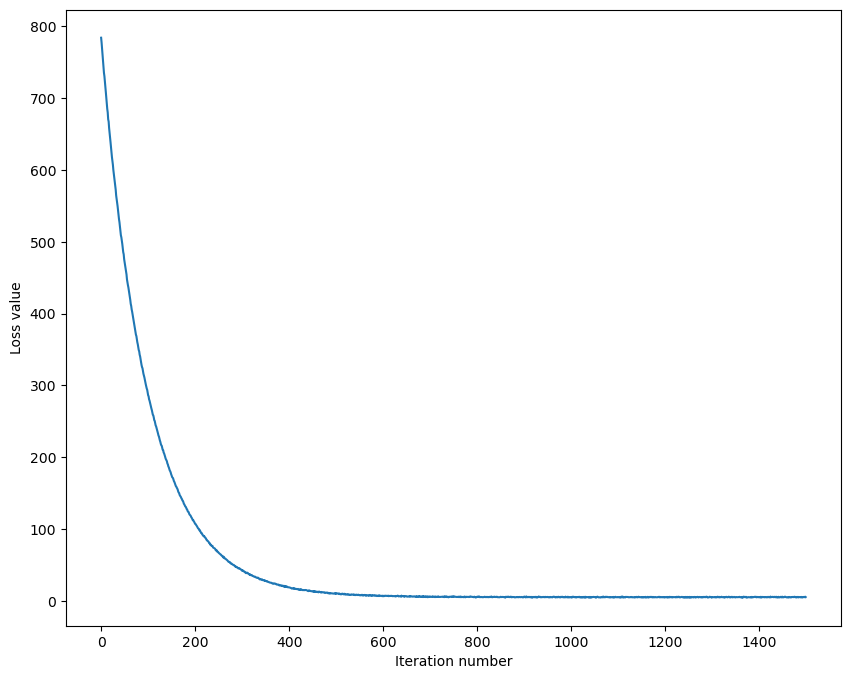

In [18]:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [19]:
# evaluate the performance on both the training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.366673
validation accuracy: 0.375000


## Tuning hyperparameters (regularization strength and learning rate)

In [20]:
# results is dictionary mapping tuples of the form(learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy).
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

learning_rates = np.geomspace(2e-7, 3e-7, 5)
regularization_strengths = np.geomspace(5e3, 5e4, 5)

import itertools

for learning_rate, regularization_strength in itertools.product(learning_rates, regularization_strengths):

    svm = LinearSVM()
    loss = svm.train(X_train, y_train, learning_rate, regularization_strength, num_iters=1000, verbose=True)
  
    y_train_pred = svm.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)

    y_val_pred = svm.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred)

    results[(learning_rate, regularization_strength)] = (training_accuracy, validation_accuracy)
    if validation_accuracy > best_val:
        best_val = validation_accuracy
        best_svm = svm

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 174.718988
iteration 100 / 1000: loss 109.826817
iteration 200 / 1000: loss 71.547123
iteration 300 / 1000: loss 50.005208
iteration 400 / 1000: loss 35.275480
iteration 500 / 1000: loss 24.572019
iteration 600 / 1000: loss 17.565387
iteration 700 / 1000: loss 14.113120
iteration 800 / 1000: loss 10.803892
iteration 900 / 1000: loss 8.646866
iteration 0 / 1000: loss 291.675374
iteration 100 / 1000: loss 139.733317
iteration 200 / 1000: loss 70.100491
iteration 300 / 1000: loss 36.922449
iteration 400 / 1000: loss 20.713571
iteration 500 / 1000: loss 12.364609
iteration 600 / 1000: loss 8.507889
iteration 700 / 1000: loss 6.288665
iteration 800 / 1000: loss 5.875412
iteration 900 / 1000: loss 5.079445
iteration 0 / 1000: loss 508.013770
iteration 100 / 1000: loss 141.923352
iteration 200 / 1000: loss 43.317052
iteration 300 / 1000: loss 15.965294
iteration 400 / 1000: loss 8.068890
iteration 500 / 1000: loss 5.787817
iteration 600 / 1000: loss 5.440593
iteration

iteration 600 / 1000: loss 5.085246
iteration 700 / 1000: loss 5.297671
iteration 800 / 1000: loss 5.624851
iteration 900 / 1000: loss 5.516084
iteration 0 / 1000: loss 878.113069
iteration 100 / 1000: loss 33.750077
iteration 200 / 1000: loss 6.158828
iteration 300 / 1000: loss 5.289607
iteration 400 / 1000: loss 5.536571
iteration 500 / 1000: loss 5.460827
iteration 600 / 1000: loss 4.839329
iteration 700 / 1000: loss 5.486902
iteration 800 / 1000: loss 5.482670
iteration 900 / 1000: loss 5.415691
iteration 0 / 1000: loss 1563.498592
iteration 100 / 1000: loss 9.746629
iteration 200 / 1000: loss 5.654020
iteration 300 / 1000: loss 5.772255
iteration 400 / 1000: loss 5.865230
iteration 500 / 1000: loss 5.923641
iteration 600 / 1000: loss 6.565774
iteration 700 / 1000: loss 5.732278
iteration 800 / 1000: loss 5.693622
iteration 900 / 1000: loss 6.020496
lr 2.000000e-07 reg 5.000000e+03 train accuracy: 0.380163 val accuracy: 0.381000
lr 2.000000e-07 reg 8.891397e+03 train accuracy: 0.38

In [22]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.370000
